Importing required libraries and the dataset

To Do:
	Look at realtionship between small fires (<= 3.2 ha) and large fires (> 3.2 ha), see if there are any correlations.
	See if the most impactful variable is the same for both
	See correlation


In [541]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras

from tensorflow.keras import layers
import os
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
import statsmodels.api as sma

#Disable tensorflow warning
tf.get_logger().setLevel('INFO')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'




The goal of this project is to predict forest fire area based on a variety of feature variables.
I will be creating both a Linear regression and a Huber regression, then will test to see which has the best fit.


Need to do data cleanup first


In [547]:
df = pd.read_csv('./forestfires.csv')
df.info()

# Change the month and day to integers
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df.replace({'month': month_dict}, inplace=True)

day_dict = {'sun': 1, 'mon': 2, 'tue': 3,
            'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7}

df.replace({'day':day_dict}, inplace=True)

large_fires = df[df['area'] > 3.2]
lf = large_fires

ns = df[df['area'] > 0]

# Make rain binary, 1 if it has rained, 0 if no
# df['rain'] = np.where(df['rain'] > 0, 1,0)
# df['area'] = [np.log(area +  1) for area in df['area']]
# df['area']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [543]:
# Correlation matrix that sorts high to low based on relationship to area
# Temperature and DMC have the highest correlation
# RH and rain are the only two variables with a negative correlation
df.corr().iloc[-1].sort_values(ascending=False)


area     1.000000
temp     0.097844
DMC      0.072994
X        0.063385
month    0.056496
DC       0.049383
day      0.048359
Y        0.044873
FFMC     0.040122
wind     0.012317
ISI      0.008258
rain    -0.007366
RH      -0.075519
Name: area, dtype: float64

Train model with tf

In [ ]:
X = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp']]
Y = df['area']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)
y_train = y_train.reset_index(drop = True)
X_train = X_train.reset_index(drop = True)

print(X_train)
print(len(y_train))

feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

X_train.shape, X_test.shape, X_val.shape

regressor = tf.compat.v1.estimator.DNNRegressor(
    feature_columns=feature_cols,  hidden_units=[50, 50], model_dir='tf_wx_model')


def wx_input_fn(X, y=None, num_epochs=None, shuffle=False, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, y=y, num_epochs=num_epochs, shuffle=shuffle, batch_size=batch_size)
evaluations = []
STEPS = 40
for i in range(10):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))


In [ ]:
loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

In [ ]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f" % median_absolute_error(
                                            y_test, predictions))

Fit model, Random Forest

The original paper only tested:
	Temperature
	Rain
	Relative Humidity
	Wind Speed

Used natural log area + 1

In [ ]:
from sklearn.model_selection import cross_val_score

Y = df['area']
Y = [np.log(area +  1) for area in Y]
X = df[['temp', 'wind','rain','RH']]


figure, axis = plt.subplots(4,1)
figure.set_figheight(10)
count = 0
for i, n in X.iteritems():
	
	feature = np.array(n)[:, np.newaxis]
	ols = LinearRegression()
	ols.fit(feature, Y)
	y_pred = ols.predict(feature)

	axis[count].set_title(i)
	axis[count].scatter(feature, Y)
	axis[count].plot(feature, y_pred, color='red')

	scores = -cross_val_score(ols, feature, Y, scoring="neg_mean_squared_error", cv=8)
	print(ols.coef_)
	print(f'{i}: {np.mean(scores)} neg mean squared error')
	count += 1



Make rain binary, if > 0 then 1, otherwise 0 then predict.

In [ ]:
X = df.loc[:,df.columns != 'area']
Y = df['area']


ols = LinearRegression()
ols.fit(X, Y)
y_pred  = ols.predict(X)

ols.intercept_



Data Cleanup:
	Split large and small fires by area
	Convert area to log
	Create X and y variables for both large and small fires

In [ ]:
# There are 341 small fires
small_fires = df[df['area'] <= 3.2]

# 176 large_fires
large_fires = df[df['area'] > 3.2]

# Convert the areas in both df to log
small_fires.loc[:, 'area'] = [np.log(area +  1) for area in small_fires['area']]
large_fires.loc[:, 'area'] = [np.log(area +  1) for area in large_fires['area']]

X_sf = small_fires.loc[:, small_fires.columns != 'area']
y_sf = small_fires.loc[:, 'area']

X_lf = large_fires.loc[:, large_fires.columns != 'area']
y_lf = large_fires.loc[:, 'area']



In [ ]:
#Run correlation to see most impactful variables

print('Small Fires: \n', small_fires.corr().iloc[-1].sort_values(ascending = False), sep = '')
print('Large Fires: \n', large_fires.corr().iloc[-1].sort_values(ascending = False), sep='')

Next, run a LinearRegression for both and look at summary

In [ ]:
# Small Fires:
X_sf = small_fires.loc[:, small_fires.columns != 'area']
y_sf = small_fires.loc[:, 'area']
X2_sf = sma.add_constant(X_sf)

sf_ols = sma.OLS(y_sf, X2_sf)
sf_est = sf_ols.fit()

# Large Fires: 
X_lf = large_fires.loc[:, large_fires.columns != 'area']
y_lf = large_fires.loc[:, 'area']
X2_lf = sma.add_constant(X_lf)

lf_ols = sma.OLS(y_lf, X2_lf)
lf_est = lf_ols.fit()

print('Small Fires:\n', sf_est.summary())
print('Large Fires:\n',lf_est.summary())
print(sf_est.pvalues)


Statistically Significant
Small Fires:
	Temp

Large Fires:
	X
	DC

Coefficients (Ignoring month):
Small Fires:
	Rain = -0.0660
	Temp = 0.0170
	Wind = 0.0116


Large Fires: 
	Temp = 0.0391
	wind = 0.0104
	rain = -0.1180

Temp has a much larger impact on the area of large fires, but can statistically significantly predict small fires.

Create a neural network to see how effectively it can predict the size of large fires.
Create an svm model and predict.

In [ ]:
# SVM First, Using Rain, temp, wind, RH
# Split into testing and training datasets
# Transform area into 0 for small fires and 1 for large fires (Necessary for SVM)
X = df.loc[:, ['rain', 'temp','wind','RH']]
y = [0 if area <= 3.2 else 1 for area in df['area']]

# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(df)

# Calculate average accuracy over 100 tests
accuracy_svc = []
accuracy_knn = []

# disp = metrics.plot_confusion_matrix(svm_model, X_test, y_test)
# plt.title("SVM Classifier")
# print(disp.confusion_matrix)

# disp_knn = metrics.plot_confusion_matrix(KNN_model, X_test, y_test)
# plt.title("KNN Classifier")
# print(disp_knn.confusion_matrix)
	
for _ in range(300):
	X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

	svm_model = SVC()
	svm_model.fit(X_train, y_train)

	KNN_model = KNeighborsClassifier(n_neighbors = 10).fit(X_train,y_train)

	y_pred_svc = svm_model.predict(X_test)
	y_pred_knn = KNN_model.predict(X_test)

	accuracy_svc.append(metrics.accuracy_score(y_test, y_pred_svc))
	accuracy_knn.append(metrics.accuracy_score(y_test, y_pred_knn))

print('SVC Accuracy : ', np.mean(accuracy_svc))
print('KNN Accuracy : ', np.mean(accuracy_knn))


In [ ]:
# Run SVM and KNN again with 4 other variables
X = df.loc[:, ['FFMC','DC','ISI','DMC']]
y = [0 if area <= 3.2 else 1 for area in df['area']]

accuracy_svc = []
accuracy_knn = []

for _ in range(300):
	X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

	svm_model = SVC()
	svm_model.fit(X_train, y_train)

	KNN_model = KNeighborsClassifier(n_neighbors = 10).fit(X_train,y_train)

	y_pred_svc = svm_model.predict(X_test)
	y_pred_knn = KNN_model.predict(X_test)

	accuracy_svc.append(metrics.accuracy_score(y_test, y_pred_svc))
	accuracy_knn.append(metrics.accuracy_score(y_test, y_pred_knn))

print('SVC Accuracy : ', np.mean(accuracy_svc))
print('KNN Accuracy : ', np.mean(accuracy_knn))


SVC has the best accuracy of predicting whether a fire will be large or small when using the 4 meterological variables

Rain wind temp rh
SVC Accuracy :  0.6628974358974359
KNN Accuracy :  0.6458717948717949

FFMC DMC DC ISI
SVC Accuracy :  0.6566410256410257
KNN Accuracy :  0.6336410256410258

Now, train an SVM regression model and predict area size for large fires only

In [ ]:
# Helper function for running a model many times to get an average accuracy score
def many_tests(x, y, n = 100):
	knn = []
	svr = []
	for _ in range(n):
		X_train, X_test, y_train, y_test = train_test_split(x, y)

		svr_model = SVR()
		svr_model.fit(X_train, y_train)

		knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 10)
		knn_model.fit(X_train, y_train)
		y_pred_knn = knn_model.predict(X_test)
		knn.append(knn_model.score(X_test, y_test))

		svr.append(svr_model.score(X_test, y_test))
	knn_score = np.mean(knn)
	svr_score = np.mean(svr)
	return [svr_score, knn_score]



In [ ]:
X = large_fires.loc[:,  ['rain','wind','temp','RH']]
y = [np.log(area + 1) for area  in large_fires['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

svr_model = SVR()
svr_model.fit(X_train, y_train)

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

plt.scatter(y_test, y_pred_knn, label='KNN Model')
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
plt.xlim([1,5])
plt.ylim([1,5])
plt.plot([1,5], [1,5], color = 'black')

y_pred = svr_model.predict(X_test)

plt.scatter(y_test, y_pred, label = 'SVR Model')
plt.legend()

print(many_tests(X, y, 100))



In [ ]:
# SVR model with actual areas, not log

large_fires = df[df['area'] > 3.2]
large_fires = large_fires[large_fires['area'] < 200]
X = large_fires.loc[:,  ['rain','wind','temp','RH']]
y = large_fires['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X)

plt.scatter(y, y_pred_svr)

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)


In [ ]:
# Without the rain variable large_fires = df[df['area'] > 3.2]
X = large_fires.loc[:,  ~large_fires.columns.isin(['area','month','day','X','Y','rain'])]
y = [np.log(area + 1) for area  in large_fires['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

svr_model = SVR()
svr_model.fit(X_train, y_train)

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print('KNN Model Score:', knn_model.score(X_test, y_test))

plt.scatter(y_test, y_pred_knn, label='KNN Model')
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
plt.xlim([1,5])
plt.ylim([1,5])
plt.plot([1,5], [1,5], color = 'black')

y_pred = svr_model.predict(X_test)
print('SVR Model Score',svr_model.score(X_test, y_test))

plt.scatter(y_test, y_pred, label = 'SVR Model')
plt.legend()


NN BFGS Algorithm

In [442]:
X = large_fires.loc[:,  ~large_fires.columns.isin(['area','X','Y','month','day','rain'])]
X = X.to_numpy()
y = [np.log(area + 1) for area in large_fires['area']]
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)


In [435]:
# Running ML models with actual area instead of log area
X = large_fires.loc[:,  ~large_fires.columns.isin(['area','X','Y','month','day','rain'])]
X = X.to_numpy()
y = large_fires['area']
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [437]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 50])
  plt.xlabel('Epoch')
  plt.ylabel('Error [AREA]')
  plt.legend()
  plt.grid(True)

Linear Regression Tensorflow

[[ 90.47879   116.34924   568.3659      8.484849   18.667423   44.045456
    4.2431817]]


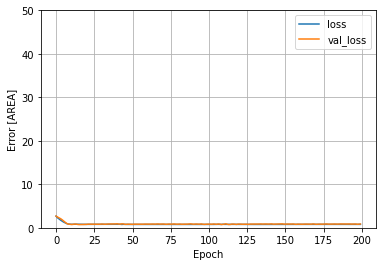

In [443]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

first = np.array(X_train[:1])

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    X_train,
    y_train,
    epochs=200,
    # Suppress logging.
    verbose=0,
	validation_split=0.3)
	
plot_loss(history)

test_results_linear = linear_model.evaluate(
    X_test, y_test, verbose=0)

DNN Regression

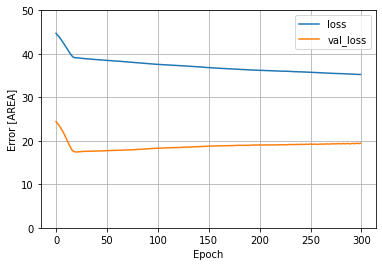

In [439]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnnr_model = build_and_compile_model(normalizer)

history = dnnr_model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    verbose=0, epochs=300)

plot_loss(history)

test_results_dnnr = dnnr_model.evaluate(X_test, y_test, verbose=0)


In [440]:
# Print test results
test_results = {'Linear Model': test_results_linear, 'DNNR': test_results_dnnr}
pd.DataFrame(test_results, index=['Mean Absolute Error'])

,Linear Model,DNNR
Mean Absolute Error,25.020716,25.765486


2/2 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'DNNR Model Predictions')

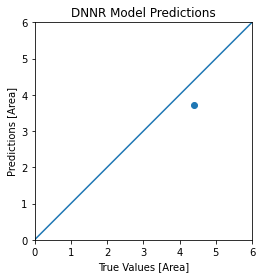

In [441]:
# Plot accuracy of DNNR

test_predictions = dnnr_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Area]')
plt.ylabel('Predictions [Area]')
plt.xlim([0,6])
plt.ylim([0,6])
_ = plt.plot([0,6], [0,6])
plt.title('DNNR Model Predictions')

2/2 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Linear Model Predictions')

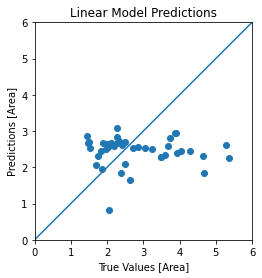

In [432]:
# Plot accuracy of linear model

test_predictions = linear_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Area]')
plt.ylabel('Predictions [Area]')
plt.xlim([0,6])
plt.ylim([0,6])
_ = plt.plot([0,6], [0,6])
plt.title("Linear Model Predictions")

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Area]')
_ = plt.ylabel('Count')

In [423]:
dnnr_model.layers[0].weights

[<tf.Variable 'mean:0' shape=(7,) dtype=float32, numpy=
 array([ 90.47879  , 116.34924  , 568.3659   ,   8.484849 ,  18.667423 ,
         44.045456 ,   4.2431817], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(7,) dtype=float32, numpy=
 array([1.7388794e+01, 5.3394224e+03, 6.2735762e+04, 1.5242043e+01,
        4.3233562e+01, 2.5030095e+02, 3.5271509e+00], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=132>]

SVR MSE:  2.290265640692473
KNN MSE:  2.2013324651843087
Random Forest MSE:  2.0929043569196875


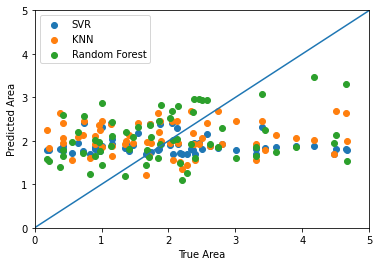

In [487]:
X = ns.loc[:, ~ns.columns.isin(['area','X','Y','month','day'])]
y = [np.log(area + 1) for area in ns['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# First run svr

svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
a = metrics.mean_squared_error(y_test, y_pred_svr)
print('SVR MSE: ', a)

knn_model = KNeighborsRegressor(n_neighbors = 18)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
b = metrics.mean_squared_error(y_test, y_pred_knn)
print('KNN MSE: ', b)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf =  rf_model.predict(X_test)
c = metrics.mean_squared_error(y_test, y_pred_rf)
print('Random Forest MSE: ', c)




# Mean squared error of 2.6227

# Now KNN, must loop to find best n_neighbors


# test = {}
# for i in range(1, 20):
# 	# Test each n_neighbors many times to get good estimate
# 	b = []
# 	for j in range(50):
# 		k = KNeighborsRegressor(n_neighbors = i)
# 		k.fit(X_train, y_train)
# 		p = k.predict(X_test)
# 		b.append(metrics.mean_squared_error(y_test, p))
# 	test[i] = np.mean(b)

# print(test)

plt.scatter(y_test, y_pred_svr, label = 'SVR')
plt.scatter(y_test, y_pred_knn, label = 'KNN')
plt.scatter(y_test, y_pred_rf, label = 'Random Forest')
plt.legend()
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
plt.xlim([0,5])
plt.ylim([0,5])
plt.plot([0,5], [0,5])


[0.01588833]


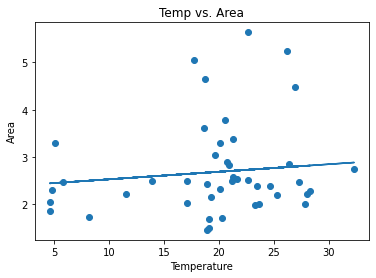

In [502]:
X = large_fires[['temp']]
y = [np.log(area + 1) for area in large_fires['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = HuberRegressor().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Temp vs. Area')
plt.xlabel('Temperature')
plt.ylabel('Area')
print(ols.coef_)


[-0.00418577]


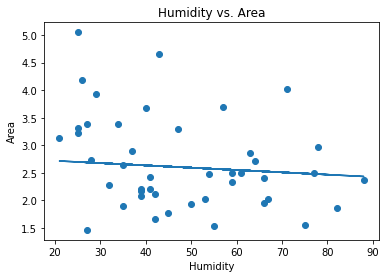

In [504]:
X = large_fires[['RH']]
y = [np.log(area + 1) for area in large_fires['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = HuberRegressor().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Humidity vs. Area')
plt.xlabel('Humidity')
plt.ylabel('Area')
print(ols.coef_)
plt.show()

[0.04117384]


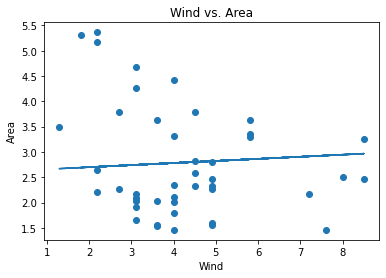

In [506]:
X = large_fires[['wind']]
y = [np.log(area + 1) for area in large_fires['area']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)
plt.title('Wind vs. Area')
plt.xlabel('Wind')
plt.ylabel('Area')
print(ols.coef_)

<AxesSubplot:>

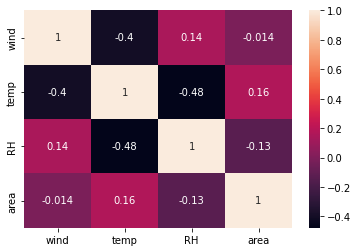

In [550]:
d = lf[['wind','temp','RH','area']].corr()
sns.heatmap(d, annot = True)
